### Import Required Packages

In [1]:
import re
import warnings
import gensim
import nltk
import pickle
import numpy as np
import pandas as pd
import sklearn
import math
import matplotlib.pyplot as plt
from scipy.stats import norm
from bs4 import BeautifulSoup
from gensim.models import Word2Vec
from gensim.test.utils import common_texts
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import LogisticRegression
from gensim.models import KeyedVectors

##### Preprocess the Data

In [2]:
def preprocess(dataset, tokenizer, rm_stopwords = False, stemmer = False):
    """
    Builds the array of sentences from the review dataset
    to be used for learning the word embeddings.
    Optional stopword extraction and stemming offered.
    """
    # Load stemmer if necessary
    stem = PorterStemmer() if stemmer else None
    stop = set(stopwords.words("english")) if rm_stopwords else None

    # Tokenize all words in the dataset
    reviews = [dataset[movie_id][1] for movie_id in dataset]

    sentences = []
    for s in reviews:

        # Remove HTML and Non-Alphabetical Terms
        parsed_s = re.sub("[^a-zA-Z]", " ", BeautifulSoup(s).get_text())
        parsed_s = tokenizer.tokenize(parsed_s.lower())

        if stop:
            if stem:
                sentences.append([stem.stem(w) for w in parsed_s if w not in stop])
            else:
                sentences.append([w for w in parsed_s if w not in stop])
        else:
            sentences.append(parsed_s)

    return sentences

In [3]:
# Remove warnings
warnings.filterwarnings(action='ignore')

# Download Necessary Files
#nltk.download('popular')

# Initialize tokenizer to parse reviews
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')

In [4]:
# Preprocess the dataset
with open("data/processed/data_train.pkl", "rb") as ratings:
    dataset = pickle.load(ratings)
with open("data/processed/data_test.pkl", "rb") as ratings:
    test_dataset = pickle.load(ratings)

words = preprocess(dataset, tokenizer, rm_stopwords=True, stemmer=True)
test_words = preprocess(test_dataset, tokenizer, rm_stopwords=True, stemmer=True)

##### Initialize Model and Formulate Training/Testing Data

In [5]:
# Initialize model parameters
num_workers = 4
min_len = 1
win_size = 7
down_samp = 1e3

In [6]:
# Initialize Google word embeddings
sg_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [7]:
def gen_data(dataset, words, w2v_model):
    """
    Generates a context vector and label for each movie
    """
    movie_vec = []
    labels = []
    for idx, movie_id in enumerate(dataset):
        mean_vec = np.mean([w2v_model[w] for w in words[idx][0].split() if w in w2v_model.key_to_index], axis = 0)
        if len(mean_vec.shape) == 0:
            mean_vec = np.random.rand(100)
        movie_vec.append(mean_vec)
        labels.append(np.array(round(dataset[movie_id][0])))

    
    contexts = np.vstack(movie_vec)
    labels = np.vstack(labels)
    
    return contexts, labels

In [8]:
# Generate training data using the sg and cb models
train_data, train_labels = gen_data(dataset, words, sg_model)
test_data, test_labels = gen_data(test_dataset, test_words, sg_model)

print(train_data.shape, train_labels.shape)

(24000, 300) (24000, 1)


In [9]:
def stats(labels, preds):
    """
    Calculates the loss given the labels and predictions
    """
    dist = {i:0 for i in range(0,11)}
    dist_lab = {i:0 for i in range(0,11)}
    error = []
    pred = []
    
    loss = 0.
    acc = 0
    for idx, val in enumerate(labels):
        curr_loss = abs(preds[idx]) - abs(labels[idx])
        error.append(abs(curr_loss))
        loss += curr_loss ** 2
        
        if curr_loss < 0.4:
            acc += 1
        
        p_idx = round(preds[idx])
        pred.append(p_idx)
        l_idx = round(labels[idx][0])
        
        if p_idx in dist:
            dist[p_idx] += 1
        else:
            dist[p_idx] = 1
        if l_idx in dist_lab:
            dist_lab[l_idx] += 1
        else:
            dist_lab[l_idx] = 1
    
    acc /= labels.shape[0]
    loss /= labels.shape[0]
    
    return acc, loss, dist, dist_lab, np.mean(error), np.std(error), np.array(pred)

In [10]:
def plot(num_estimators, reg, title):
    """
    Plots the loss over iteration curve of a given model.
    """
    
    plt.title(title)
    plt.plot(
        np.arange(num_estimators) + 1,
        reg.train_score_,
        "b-",
        label="Training Loss",
    )
    plt.show()

##### Random Forest Model

In [11]:
num_estimators = 50
min_samples = 3

# Initialize Random Forest Regressor
clf_sg = RandomForestRegressor(
    n_estimators = num_estimators,
    min_samples_split = min_samples,
    max_features= 'auto',
    max_depth = 10)

In [12]:
# Training on sg data
clf_sg.fit(train_data, train_labels)

RandomForestRegressor(max_depth=10, min_samples_split=3, n_estimators=50)

In [13]:
# Evaluate training accuracy
sg_pred = clf_sg.predict(train_data)
p_stats = stats(train_labels, sg_pred)
print(f"SG Random Forest Accuracy: {p_stats[0]:.4f}, Loss: {p_stats[1][0]:.4f}, \
      Mean Error: {p_stats[4]:.4f}, Standard Deviation: {p_stats[5]:.4f}")

SG Random Forest Accuracy: 0.7097, Loss: 0.7414,       Mean Error: 0.6794, Standard Deviation: 0.5290


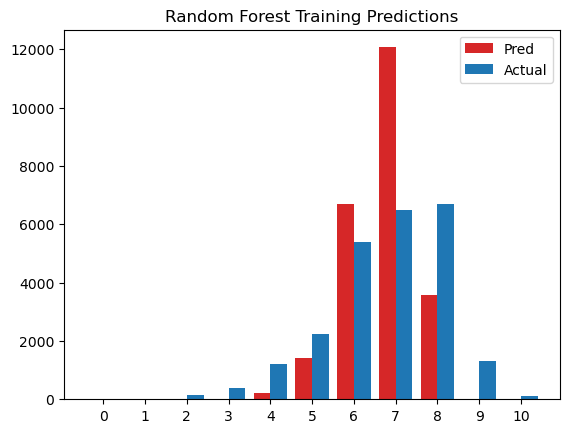

In [14]:
preds = [p_stats[2][i] for i in p_stats[2]]
labs = [p_stats[3][i] for i in p_stats[3]]

x1 = [i - 0.2 for i in p_stats[2]]
x2 = [i + 0.2 for i in p_stats[2]]
X_axis = [i for i in p_stats[2]]
plt.xticks(X_axis, X_axis)

plt.bar(x1, preds, 0.4,  color = 'tab:red', label = "Pred")
plt.bar(x2, labs, 0.4, color = 'tab:blue', label = "Actual")
plt.legend()
plt.title("Random Forest Training Predictions")
plt.show()

In [15]:
# Evaluate results on test set
sg_pred_t = clf_sg.predict(test_data)
p_stats = stats(test_labels, sg_pred_t)
print(f"SG Random Forest Testing Accuracy: {p_stats[0]:.4f}, Loss: {p_stats[1][0]:.4f}, \
      Mean Error: {p_stats[4]:.4f}, Standard Deviation: {p_stats[5]:.4f}")

SG Random Forest Testing Accuracy: 0.6845, Loss: 1.3310,       Mean Error: 0.8970, Standard Deviation: 0.7256


In [16]:
with open('results_rf.pkl','wb') as fp:
    pickle.dump(p_stats[6], fp)
print(p_stats[6])

[7 7 6 ... 4 6 7]


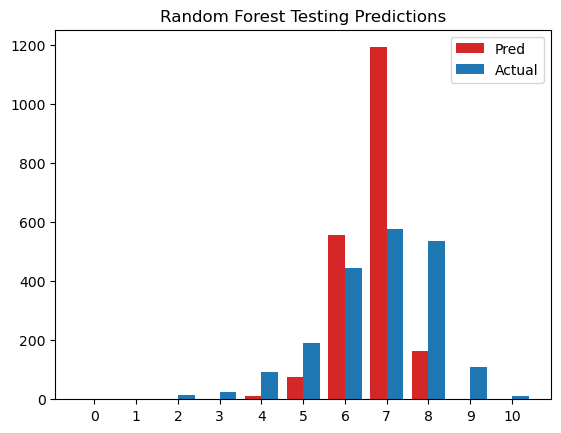

In [17]:
p_test = [p_stats[2][i] for i in p_stats[2]]
labels = [p_stats[3][i] for i in p_stats[3]]

x1 = [i - 0.2 for i in p_stats[2]]
x2 = [i + 0.2 for i in p_stats[2]]
X_axis = [i for i in p_stats[2]]
plt.xticks(X_axis, X_axis)


plt.bar(x1, p_test, 0.4, color = 'tab:red', label = "Pred")
plt.bar(x2, labels, 0.4, color = 'tab:blue', label = "Actual")
plt.legend()
plt.title("Random Forest Testing Predictions")
plt.show()

##### Gradient Boosting Model

In [18]:
# Initialize Gradient Boosting Regressor
clf_gb = GradientBoostingRegressor(
    loss='squared_error', 
    learning_rate=0.1, 
    n_estimators=num_estimators,  
    criterion='friedman_mse', 
    min_samples_split=min_samples)

In [19]:
# Training on sg data
clf_gb.fit(train_data, train_labels)

GradientBoostingRegressor(min_samples_split=3, n_estimators=50)

Plot the loss over iterations for the Gradient Boosting Model.

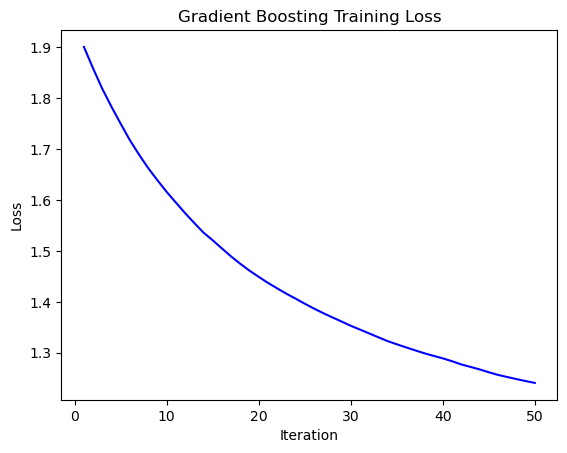

In [20]:
plt.title("Gradient Boosting Training Loss")
plt.plot(
    np.arange(num_estimators) + 1,
    clf_gb.train_score_,
    "b-",
    label="Training Loss"
)
plt.xlabel("Iteration")
plt.ylabel("Loss")
plt.show()

In [21]:
# Evaluate training accuracy
gb_pred = clf_gb.predict(train_data)
p_stats = stats(train_labels, gb_pred)
print(f"SG Gradient Boosting Accuracy: {p_stats[0]:.4f}, Loss: {p_stats[1][0]:.4f}, \
      Mean Error: {p_stats[4]:.4f}, Standard Deviation: {p_stats[5]:.4f}")

SG Gradient Boosting Accuracy: 0.6800, Loss: 1.2407,       Mean Error: 0.8655, Standard Deviation: 0.7012


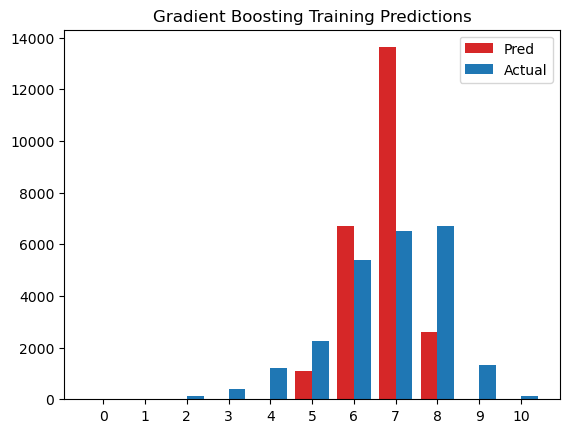

In [22]:
preds = [p_stats[2][i] for i in p_stats[2]]
labs = [p_stats[3][i] for i in p_stats[3]]

x1 = [i - 0.2 for i in p_stats[2]]
x2 = [i + 0.2 for i in p_stats[2]]
X_axis = [i for i in p_stats[2]]
plt.xticks(X_axis, X_axis)

plt.bar(x1, preds, 0.4,  color = 'tab:red', label = "Pred")
plt.bar(x2, labs, 0.4, color = 'tab:blue', label = "Actual")
plt.legend()
plt.title("Gradient Boosting Training Predictions")
plt.show()

In [23]:
# Evaluate results on test set
gb_pred_t = clf_gb.predict(test_data)
p_stats = stats(test_labels, gb_pred_t)
print(f"SG Gradient Boosting Testing Accuracy: {p_stats[0]:.4f}, Loss: {p_stats[1][0]:.4f}, \
      Mean Error: {p_stats[4]:.4f}, Standard Deviation: {p_stats[5]:.4f}")

with open('results_gb.pkl','wb') as fp:
    pickle.dump(p_stats[6], fp)

SG Gradient Boosting Testing Accuracy: 0.6790, Loss: 1.3238,       Mean Error: 0.8890, Standard Deviation: 0.7305


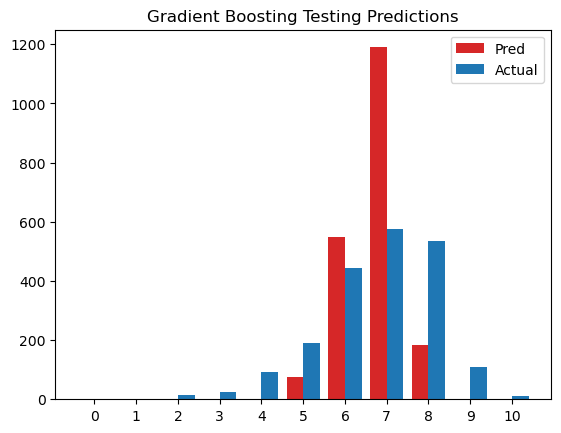

In [24]:
preds = [p_stats[2][i] for i in p_stats[2]]
labs = [p_stats[3][i] for i in p_stats[3]]

x1 = [i - 0.2 for i in p_stats[2]]
x2 = [i + 0.2 for i in p_stats[2]]
X_axis = [i for i in p_stats[2]]
plt.xticks(X_axis, X_axis)

plt.bar(x1, preds, 0.4,  color = 'tab:red', label = "Pred")
plt.bar(x2, labs, 0.4, color = 'tab:blue', label = "Actual")
plt.legend()
plt.title("Gradient Boosting Testing Predictions")
plt.show()

##### Logistic Regression Model

In [25]:
LR_model = LogisticRegression(penalty='l2',
    solver='lbfgs', 
    max_iter=200, 
    multi_class='auto',
    class_weight = 'balanced'
)

In [26]:
LR_model.fit(train_data, train_labels)

LogisticRegression(class_weight='balanced', max_iter=200)

In [27]:
lr_pred = LR_model.predict(train_data)
p_stats = stats(train_labels, lr_pred)
print(f"SG Logistic Regression Accuracy: {p_stats[0]:.4f}, Loss: {p_stats[1][0]:.4f}, \
      Mean Error: {p_stats[4]:.4f}, Standard Deviation: {p_stats[5]:.4f}")

SG Logistic Regression Accuracy: 0.6622, Loss: 4.7385,       Mean Error: 1.5015, Standard Deviation: 1.5761


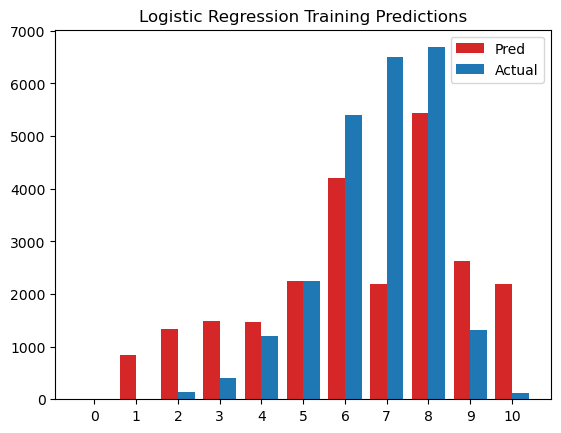

In [28]:
preds = [p_stats[2][i] for i in p_stats[2]]
labs = [p_stats[3][i] for i in p_stats[3]]

x1 = [i - 0.2 for i in p_stats[2]]
x2 = [i + 0.2 for i in p_stats[2]]
X_axis = [i for i in p_stats[2]]
plt.xticks(X_axis, X_axis)

plt.bar(x1, preds, 0.4,  color = 'tab:red', label = "Pred")
plt.bar(x2, labs, 0.4, color = 'tab:blue', label = "Actual")
plt.legend()
plt.title("Logistic Regression Training Predictions")
plt.show()

In [29]:
lr_pred_t = LR_model.predict(test_data)
p_stats = stats(test_labels, lr_pred_t)
print(f"SG Logistic Regression Testing Accuracy: {p_stats[0]:.4f}, Loss: {p_stats[1][0]:.4f}, \
      Mean Error: {p_stats[4]:.4f}, Standard Deviation: {p_stats[5]:.4f}")

with open('results_lr.pkl','wb') as fp:
    pickle.dump(p_stats[6], fp)

SG Logistic Regression Testing Accuracy: 0.6480, Loss: 4.4840,       Mean Error: 1.4750, Standard Deviation: 1.5193


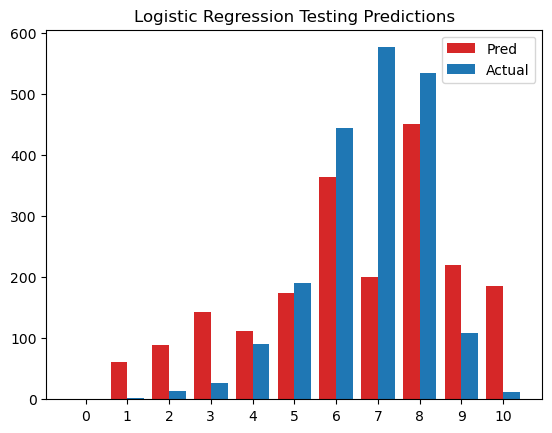

In [30]:
preds = [p_stats[2][i] for i in p_stats[2]]
labs = [p_stats[3][i] for i in p_stats[3]]

x1 = [i - 0.2 for i in p_stats[2]]
x2 = [i + 0.2 for i in p_stats[2]]
X_axis = [i for i in p_stats[2]]
plt.xticks(X_axis, X_axis)

plt.bar(x1, preds, 0.4,  color = 'tab:red', label = "Pred", alpha = 1)
plt.bar(x2, labs, 0.4, color = 'tab:blue', label = "Actual", alpha = 1)
plt.legend()
plt.title("Logistic Regression Testing Predictions")
plt.show()